# (02) CIFAR—PoisLin—1

**Motivation**: Warm restart = 2. Conclusion: bad. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('CIFAR10-PATCHES', model_type, 'lin|lin')
cfg_tr['warm_restart'] = 2

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'CIFAR10-PATCHES', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -3.0, 'prior_log_dist': 'uniform', 
'rmax_q': 1.0, 'enc_type': 'lin', 'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False}

Trainer:
{'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'temp_start': 1.0, 'temp_stop': 0.05, 'lr': 0.005, 
'batch_size': 1000, 'epochs': 1800, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'warm_restart': 2}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(1)_CIFAR10-PATCHES_z-512_<lin|lin>
mc_b1000-ep1800-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_05_03,21:00)

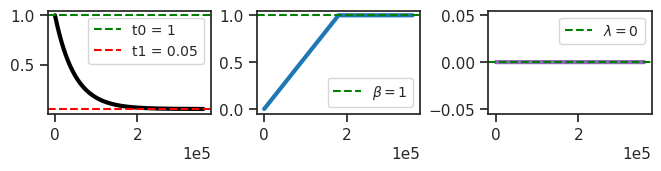

In [5]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (fc_enc): Linear(in_features=256, out_features=512, bias=False)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [7]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

### Train

In [8]:
comment = f"warm{tr.cfg.warm_restart}_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 1800, avg loss: 165.703162: 100%|███████████████████████| 1800/1800 [41:11<00:00,  1.37s/it]


### Loss vld (freeze)

In [9]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 134.4822, 'kl': 33.307636, 'kl_diag': 0.065053985, 'tot': 167.78983}

### Identify dead neurons

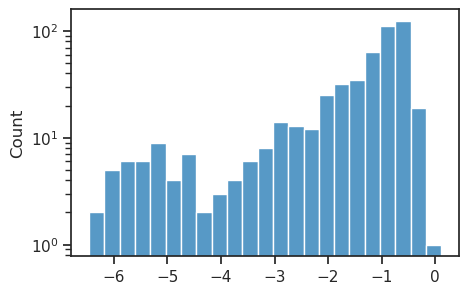

In [11]:
ax = sns.histplot(tonp(vae.log_rates.squeeze()))
ax.set_yscale('log')

In [12]:
dead_thres = 0.01
dead = np.logical_or(
    tonp(vae.log_rates.squeeze()) > 0,
    loss['kl_diag'] < dead_thres
)
dead.sum()

44

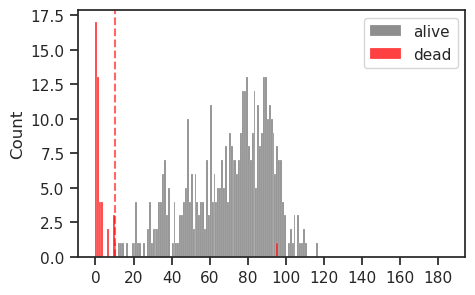

In [15]:
bins = np.linspace(0, 185, 186)
ax = sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive')
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

### Spike counts

In [16]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
print(percents)

{'0': 69.6, '1': 22.6, '2': 5.8, '3': 1.4, '4+': 0.5}

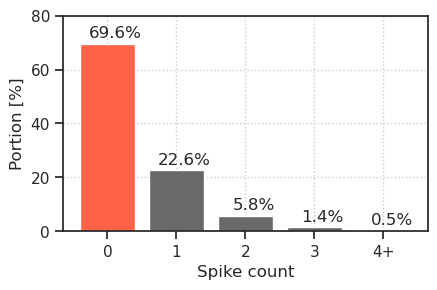

In [17]:
fig, ax = create_figure(1, 1, (4.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)
colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

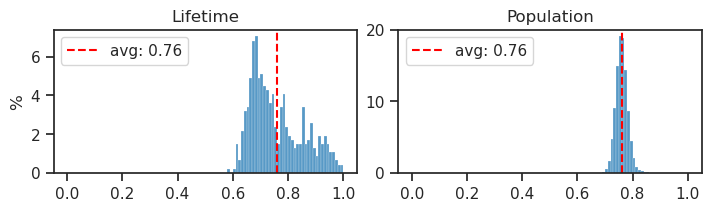

In [18]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

bins = np.linspace(0.0, 1.0, 101)
sns.histplot(lifetime, stat='percent', bins=bins, ax=axes[0])
sns.histplot(population, stat='percent', bins=bins, ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [32]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
print(lifetime.mean(), population.mean())

0.7589126 0.7607156

In [34]:
lifetime, population, percents = sparse_score(rates['r*dr'][:, ~dead], cutoff=0.05)
print(lifetime.mean(), population.mean())

0.3739624 0.4161582

In [19]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(136.0, 275.0)

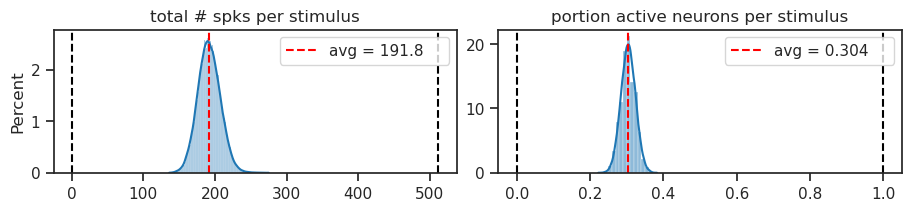

In [20]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

### Cosine sim enc/dec

In [21]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

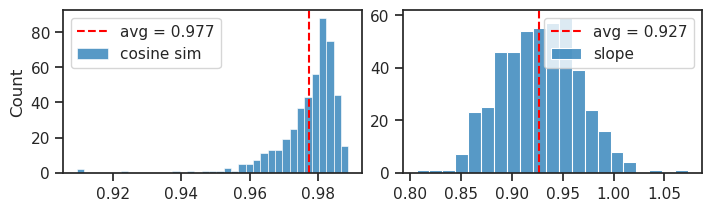

In [22]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(tonp(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(tonp(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot enc/dec weights

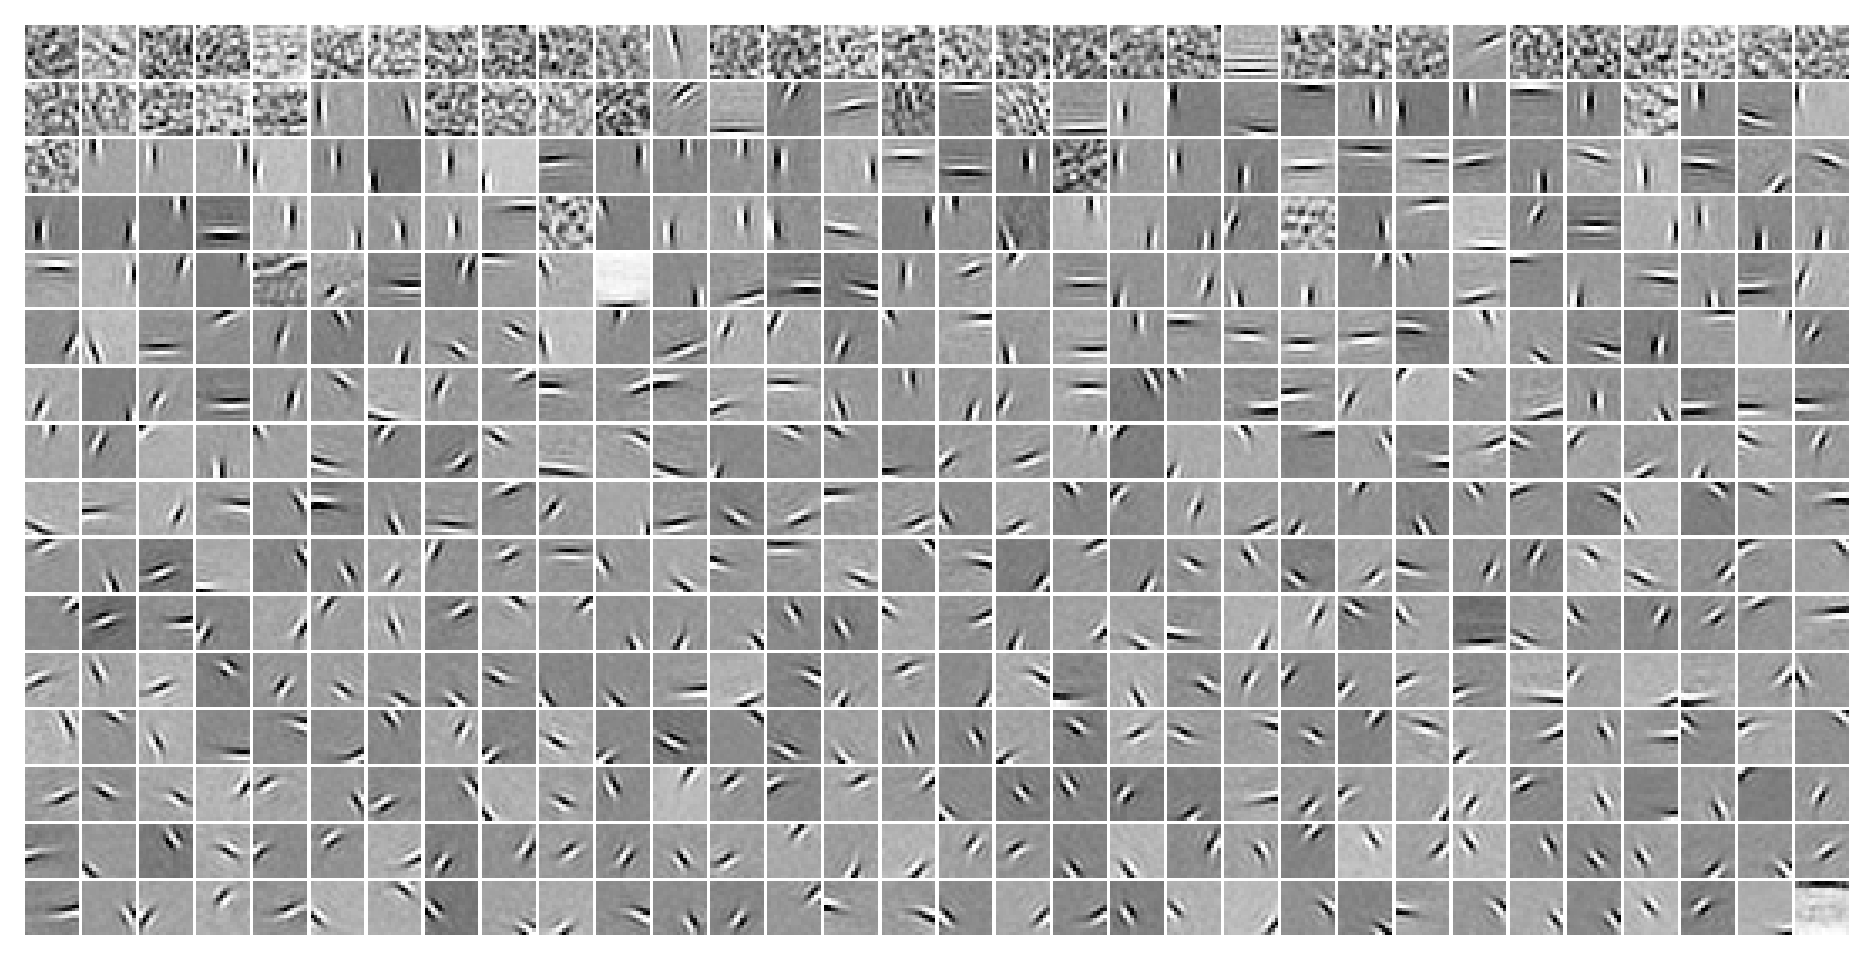

In [23]:
vae.show(dpi=250, order=np.argsort(tonp(vae.log_rates.squeeze())));

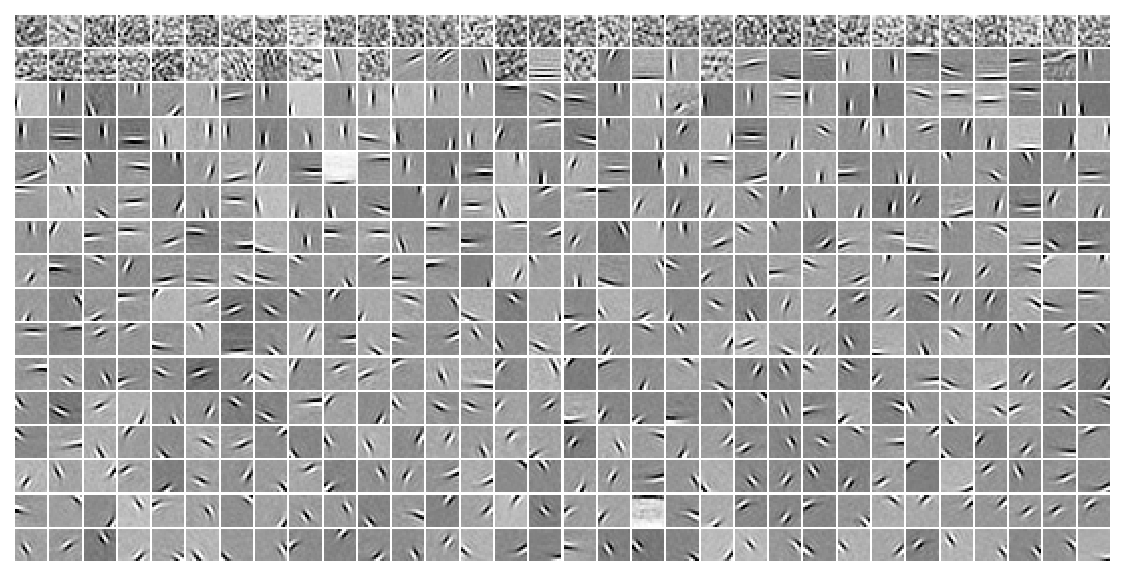

In [24]:
vae.show(dpi=150, order=np.argsort(loss['kl_diag']));

### Some more distributions

In [25]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0505, device='cuda:1'), 1.0)

In [27]:
prior_rates = tonp(vae.log_rates).squeeze()[~dead]

mu = prior_rates.mean()
sd = prior_rates.std()

rv = sp_stats.norm(loc=mu, scale=sd)
xs = np.linspace(-2.1, 1.1, 100)
pdf = rv.pdf(xs)

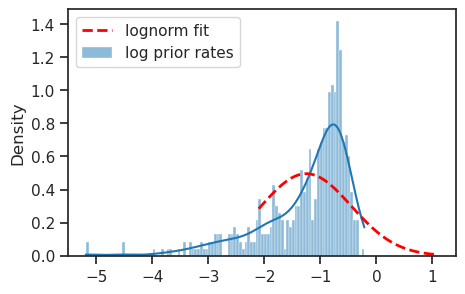

In [28]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=100, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [29]:
vae.log_rates.squeeze()[dead]

tensor([-5.2817, -5.7006, -3.0497, -5.0420, -4.6871, -5.3461, -6.0035, -5.1537,
        -4.7716, -4.0365, -2.9621, -5.5211, -4.5250, -5.8253, -5.1539, -6.0355,
        -5.3314, -5.0240, -4.5253, -3.4650, -5.1754, -4.8468, -4.6234, -5.6637,
        -5.3464, -5.7921, -5.6172, -5.9949, -5.4912, -5.5077, -6.3068, -4.5763,
        -3.6267, -6.4580, -5.0763, -5.2015, -4.0039, -5.8598, -5.9429,  0.1119,
        -6.0002, -4.1987, -4.4053, -4.9572], device='cuda:1',
       grad_fn=<IndexBackward0>)

In [30]:
loss['kl_diag'][dead]

array([0.00118122, 0.00090229, 0.00904316, 0.00134538, 0.00185636,
       0.00089513, 0.0004966 , 0.00118167, 0.00215326, 0.00373631,
       0.00941169, 0.00093505, 0.00322588, 0.00055108, 0.00151507,
       0.00044676, 0.00094071, 0.00137396, 0.00193849, 0.00635026,
       0.00135466, 0.00184717, 0.00211644, 0.00930741, 0.00109052,
       0.00067324, 0.00081875, 0.00060633, 0.00095699, 0.00092536,
       0.00040513, 0.0024764 , 0.0065374 , 0.00039104, 0.00127682,
       0.00112258, 0.00344255, 0.00063802, 0.00052321, 0.09508838,
       0.00064723, 0.00332938, 0.00283691, 0.00146074], dtype=float32)